In [1]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector

In [2]:
FPT = pd.read_csv('/content/CMG.csv', sep=";")
FPT = FPT.dropna()  # Xóa các giá trị bị thiếu
FPT = FPT.reset_index(drop=True)  # Đặt lại chỉ mục

FPT

,Date,Price,High,Low
0,15/12/2016,9602.3,9602.3,9602.3
1,16/12/2016,9352.8,9352.8,9352.8
2,19/12/2016,9352.8,9352.8,9352.8
3,21/12/2016,9415.2,9415.2,9228.1
4,23/12/2016,9321.7,9321.7,8978.7
...,...,...,...,...
1739,11/12/2023,38850.0,38850.0,38300.0
1740,12/12/2023,39000.0,39000.0,38300.0
1741,13/12/2023,38900.0,38900.0,37000.0
1742,14/12/2023,38900.0,38900.0,38350.0


In [3]:
# Xử lý dữ liệu
prices = FPT['Price']

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

# 7:3


In [5]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.3)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [6]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [7]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
19/19 [==============================] - 5s 20ms/step - loss: 0.0171
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 3/100
19/19 [==============================] - 0s 20ms/step - loss: 5.6063e-04
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 3.9546e-04
Epoch 5/100
19/19 [==============================] - 0s 19ms/step - loss: 3.6469e-04
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 3.4590e-04
Epoch 7/100
19/19 [==============================] - 0s 20ms/step - loss: 3.3849e-04
Epoch 8/100
19/19 [==============================] - 0s 19ms/step - loss: 3.2468e-04
Epoch 9/100
19/19 [==============================] - 0s 19ms/step - loss: 3.1636e-04
Epoch 10/100
19/19 [==============================] - 0s 20ms/step - loss: 3.1012e-04
Epoch 11/100
19/19 [==============================] - 0s 19ms/step - loss: 3.1619e-04
Epoch 12/100
19/19 [==============================] - 0s 19ms/step - lo

In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(FPT) + 1,len(FPT) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

16/16 [==============================] - 1s 5ms/step
[[1745]
 [1746]
 [1747]
 [1748]
 [1749]
 [1750]
 [1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]]
1/1 [==============================] - 0s 37ms/step
[44378.61  44488.793 44739.254 45743.465 46156.684 46370.793 46168.016
 46008.367 47201.688 46963.824 47217.555 47212.574 47050.062 49158.63
 48886.383 47505.418 48705.46  48449.3   48472.137 48688.133 48621.586
 48547.547 48115.617 36547.4   39225.38  38651.355 38590.215 38500.81
 38702.7   38601.086]


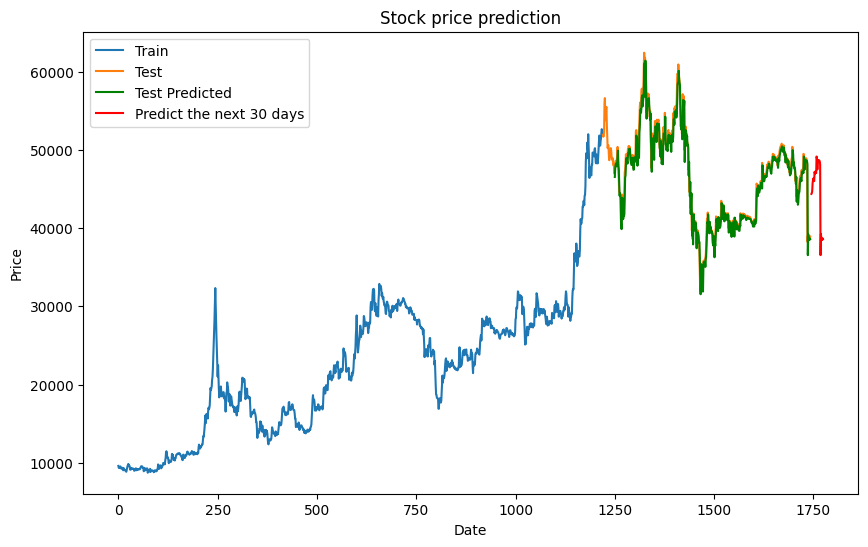

In [12]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock price prediction')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

16/16 [==============================] - 0s 6ms/step


In [14]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1296.129
MAPE: 1.87
MAE: 870.329


# 8:2

In [15]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.2)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [16]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [17]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
22/22 [==============================] - 4s 20ms/step - loss: 0.0269
Epoch 2/100
22/22 [==============================] - 1s 32ms/step - loss: 0.0019
Epoch 3/100
22/22 [==============================] - 1s 30ms/step - loss: 4.8023e-04
Epoch 4/100
22/22 [==============================] - 1s 31ms/step - loss: 4.1152e-04
Epoch 5/100
22/22 [==============================] - 1s 30ms/step - loss: 3.9848e-04
Epoch 6/100
22/22 [==============================] - 1s 31ms/step - loss: 3.7866e-04
Epoch 7/100
22/22 [==============================] - 0s 21ms/step - loss: 3.7134e-04
Epoch 8/100
22/22 [==============================] - 1s 28ms/step - loss: 3.5988e-04
Epoch 9/100
22/22 [==============================] - 1s 49ms/step - loss: 3.5425e-04
Epoch 10/100
22/22 [==============================] - 1s 41ms/step - loss: 3.4702e-04
Epoch 11/100
22/22 [==============================] - 1s 31ms/step - loss: 3.4013e-04
Epoch 12/100
22/22 [==============================] - 1s 37ms/step - lo

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(FPT) + 1,len(FPT) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

10/10 [==============================] - 1s 8ms/step
[[1745]
 [1746]
 [1747]
 [1748]
 [1749]
 [1750]
 [1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]]
1/1 [==============================] - 0s 71ms/step
[44061.664 44198.01  44473.086 45508.414 45923.887 46120.848 45933.887
 45780.14  46920.46  46681.777 46921.04  46929.188 46765.277 48957.94
 48677.676 47377.41  48404.02  48128.188 48121.855 48382.727 48295.01
 48217.414 47841.723 37311.81  39261.234 38423.01  38246.324 38342.645
 38509.113 38448.723]


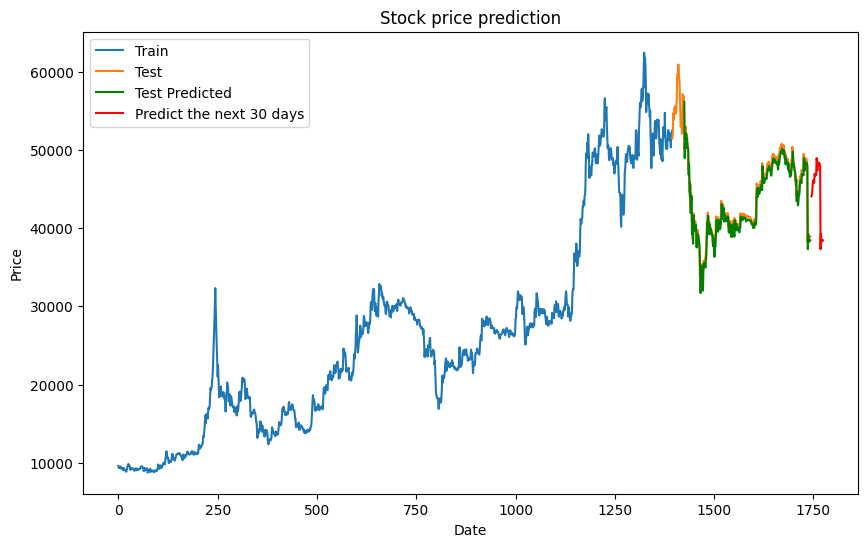

In [22]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock price prediction')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

10/10 [==============================] - 0s 7ms/step


In [24]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1199.993
MAPE: 1.938
MAE: 829.531


# 9:1

In [25]:
# Chia dữ liệu thành tập train test
np.random.seed(42)

train_size = int(len(scaled_prices) * 0.9)
test_size = int(len(scaled_prices) * 0.1)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [26]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(FPT, time_steps):
    X, y = [], []
    for i in range(len(FPT) - time_steps):
        X.append(FPT[i:i+time_steps])
        y.append(FPT[i+time_steps])
    return np.array(X), np.array(y)

In [27]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
#model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100
25/25 [==============================] - 5s 31ms/step - loss: 0.0525
Epoch 2/100
25/25 [==============================] - 1s 34ms/step - loss: 0.0016
Epoch 3/100
25/25 [==============================] - 1s 25ms/step - loss: 6.1941e-04
Epoch 4/100
25/25 [==============================] - 0s 19ms/step - loss: 5.5311e-04
Epoch 5/100
25/25 [==============================] - 0s 20ms/step - loss: 6.1578e-04
Epoch 6/100
25/25 [==============================] - 1s 20ms/step - loss: 5.6220e-04
Epoch 7/100
25/25 [==============================] - 0s 19ms/step - loss: 4.6301e-04
Epoch 8/100
25/25 [==============================] - 1s 20ms/step - loss: 4.5030e-04
Epoch 9/100
25/25 [==============================] - 1s 25ms/step - loss: 4.2488e-04
Epoch 10/100
25/25 [==============================] - 1s 40ms/step - loss: 4.2530e-04
Epoch 11/100
25/25 [==============================] - 1s 48ms/step - loss: 4.2902e-04
Epoch 12/100
25/25 [==============================] - 1s 37ms/step - lo

In [31]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(FPT) + 1,len(FPT) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

5/5 [==============================] - 0s 6ms/step
[[1745]
 [1746]
 [1747]
 [1748]
 [1749]
 [1750]
 [1751]
 [1752]
 [1753]
 [1754]
 [1755]
 [1756]
 [1757]
 [1758]
 [1759]
 [1760]
 [1761]
 [1762]
 [1763]
 [1764]
 [1765]
 [1766]
 [1767]
 [1768]
 [1769]
 [1770]
 [1771]
 [1772]
 [1773]
 [1774]]
1/1 [==============================] - 0s 24ms/step
[44849.73  44978.64  45280.95  46277.35  46690.633 46982.84  46758.066
 46568.55  47723.59  47473.098 47827.906 47750.28  47619.836 49668.105
 49420.82  48297.945 49276.637 48886.254 49037.664 49194.5   49145.08
 49082.56  48705.906 37604.637 39701.23  39069.8   39119.125 38983.66
 39187.33  39105.86 ]


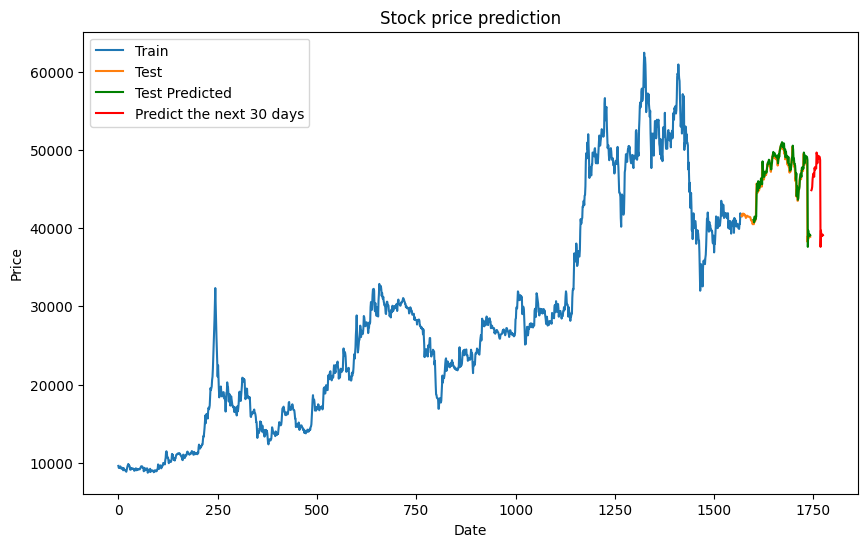

In [32]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict the next 30 days')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock price prediction')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

5/5 [==============================] - 0s 5ms/step


In [34]:
mape_test *= 100
print("RMSE:", round(rmse_test,3))
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))

RMSE: 1125.471
MAPE: 1.286
MAE: 583.046
